In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from trajectory.segments import * 
from trajectory.planner import * 
from trajectory.plot import * 
import matplotlib.pyplot as plt
from IPython.display import display
import trajectory as tj
import pandas as pd
from math import sqrt

In [2]:
# Test the error of the inital_parameters() function

from trajectory.planner import accel_tx, v_c_max, max_v0_for_x, inital_parameters

from random import randint, random



rows = []
for i in range(10000):
    v_max = randint(300,10000)
    a_max = randint(v_max*15,v_max*25)
    
    x = randint(10,v_max)
    v_0 = randint(0,v_max)
    v_1 = randint(0,v_max)
    
    args = (x, v_0, v_max, v_1, a_max)
    r = inital_parameters(*args)

    d = { k:v for k,v in zip('x_in v_0_in v_c_in v_1_in a_max'.split(),args)}
    d.update(r._asdict())
    rows.append(d)
        
df = pd.DataFrame(rows)
df['x_r'] = df.x_a + df.x_c + df.x_d
df['eq'] = df.x_in == df.x_r
df['err'] =  ((df.x_in - df.x_r).abs()/df.x_in) 
t = df[ (df.is_triangle==True) & (df['eq'] == False) ].copy()


assert df.err.mean() < .001 # Less than .1 %
df.err.mean()

0.0005360369642065551

In [5]:
# Run 1000 random moves on 6 joints

import datetime

N = 1000

sl = SegmentList([Joint(5_000, 50_000),
                  Joint(10_000, 200_000),
                  Joint(10_000, 20_000),
                  Joint(5_000, 50_000),
                  Joint(5_000, 50_000),
                  Joint(5_000, 50_000)
                 ]
                )


moves = [ [randint(-2000,2000) for _ in sl.joints] for i in range(N) ]

start = datetime.datetime.now()

for move  in moves:
    
    try:
        sl.rmove(move)
    except Exception as e:
        print(move)
        raise


finish = datetime.datetime.now()
print( (finish-start)/N)

#plot_segment_list(sl.dataframe)
#sl.dataframe.sample(10)

[1622, 315, -1240, 258, -48, 1998]


ZeroDivisionError: float division by zero

In [23]:
# Test random segments, without segment-to-segment interactions

N = 20

inputs = []

joints = [Joint(5_000, 50_000), Joint(5_000, 50_000), Joint(5_000, 50_000)]
sl = SegmentList(joints)   

for i in range(N):
    moves = [randint(-2000,2000) for _ in sl.joints] 

    limits = []
    for j in sl.joints:
        v_0_max = randint(0,j.v_max)
        v_0 = randint(0,j.v_max)
        v_1_max = randint(0,j.v_max)
        limits.append( (v_0_max, v_0 , v_1_max) )
        
    inputs.append( (moves, limits) )
      

In [34]:


# x, v_0, v_1, v_max, a_max
av = (5000,50_000)
args_set = [
    ( 100, 0, 0, *av),
    ( 250, 0, 0, *av),
    ( 500, 0, 0, *av),
    ( 750, 0, 0, *av),
    ( 1000, 0, 0, *av),
    ( 5000, 0, 0, *av),
    
    ( 10, 0, 0, *av),
    ( 100, 0, 0, *av),
    ( 100, 100, 0, *av),
    ( 100, 200, 0, *av),
    ( 100, 500, 0, *av),
    ( 100, 1000, 0, *av),
    
    ( 1000, 0, 0, *av),
    ( 1000, 100, 0, *av),
    ( 1000, 200, 0, *av),
    ( 1000, 500, 0, *av),
    ( 1000, 1000, 0, *av),    
    
    

]

for args in args_set:
    print (args, classify(*args))



(100, 0, 0, 5000, 50000) JSClass.TRIANGLE
(250, 0, 0, 5000, 50000) JSClass.TRIANGLE
(500, 0, 0, 5000, 50000) JSClass.TRAPZEZOID
(750, 0, 0, 5000, 50000) JSClass.TRAPZEZOID
(1000, 0, 0, 5000, 50000) JSClass.TRAPZEZOID
(5000, 0, 0, 5000, 50000) JSClass.TRAPZEZOID
(10, 0, 0, 5000, 50000) JSClass.TRIANGLE
(100, 0, 0, 5000, 50000) JSClass.TRIANGLE
(100, 100, 0, 5000, 50000) JSClass.CLIFF
(100, 200, 0, 5000, 50000) JSClass.CLIFF
(100, 500, 0, 5000, 50000) JSClass.CLIFF
(100, 1000, 0, 5000, 50000) JSClass.CLIFF
(1000, 0, 0, 5000, 50000) JSClass.TRAPZEZOID
(1000, 100, 0, 5000, 50000) JSClass.CLIFF
(1000, 200, 0, 5000, 50000) JSClass.CLIFF
(1000, 500, 0, 5000, 50000) JSClass.CLIFF
(1000, 1000, 0, 5000, 50000) JSClass.CLIFF


[((991, 3270, 2029, 5000, 50000), 'TRAPZEZOID'),
 ((491, 4113, 5000, 5000, 50000), 'TRAPZEZOID'),
 ((646, 3407, 4052, 5000, 50000), 'TRAPZEZOID'),
 ((546, 0, 0, 5000, 50000), 'TRAPZEZOID'),
 ((985, 1309, 4067, 5000, 50000), 'TRAPZEZOID'),
 ((944, 4496, 1129, 5000, 50000), 'TRAPZEZOID'),
 ((606, 2337, 2051, 5000, 50000), 'TRAPZEZOID'),
 ((514, 1783, 2992, 5000, 50000), 'TRAPZEZOID'),
 ((560, 3763, 556, 5000, 50000), 'TRAPZEZOID'),
 ((373, 4927, 5000, 5000, 50000), 'TRAPZEZOID'),
 ((545, 441, 0, 5000, 50000), 'CLIFF'),
 ((987, 3106, 0, 5000, 50000), 'CLIFF'),
 ((836, 2502, 0, 5000, 50000), 'CLIFF'),
 ((418, 558, 0, 5000, 50000), 'CLIFF'),
 ((559, 904, 0, 5000, 50000), 'CLIFF'),
 ((202, 1662, 0, 5000, 50000), 'CLIFF'),
 ((270, 5000, 0, 5000, 50000), 'CLIFF'),
 ((257, 1856, 0, 5000, 50000), 'CLIFF'),
 ((381, 3522, 0, 5000, 50000), 'CLIFF'),
 ((869, 2426, 0, 5000, 50000), 'CLIFF'),
 ((173, 3548, 3826, 5000, 50000), 'TROUGH'),
 ((188, 4748, 425, 5000, 50000), 'TROUGH'),
 ((30, 3444, 2552, 50

In [7]:
        
frames = []

def test_sl(moves, limits):
    from trajectory.planner import ValidationError, ConvergenceError
    sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000), Joint(5_000, 50_000)])   
    s = sl.rmove(moves)  
    
    for js, (v_0_max, v_0, v_1_max) in zip(s,limits):
        js.v_0_max = v_0_max
        js.v_0 = v_0
        js.v_1_max = v_1_max
        
    s.update()
    
    sl.validate()
    
    return s


for i, (moves, limits) in enumerate(inputs):

    try:
        s = test_sl(moves, limits)
        
        v_0_in = [e[1] for e in limits]
        v_0_out = [js.v_0 for js in s]
        
        frames.append(s.params)
    except Exception as e:
        print('E ', type(e), i, e)

df = pd.concat(frames)
df[df.err_x > 1].sort_values('err_x', ascending=False)

,seg,js,seg_t,x,t,dir,v_0_max,v_0,x_a,t_a,...,v_c_max,v_c,x_d,t_d,v_1,v_1_max,calc_x,sum_x,calc_t,err_x
2,0,2,0.3462,1231,0.3462,1,550,550,147.454462,0.06658,...,5000,3928,76.930022,0.02334,2712,2712,1233,1231,0.345304,2.1911
0,0,0,0.4502,216,0.4502,1,2197,2197,47.269924,0.03762,...,5000,409,0.000000,0.00000,409,4987,218,216,0.448857,1.7499
0,0,0,0.4274,1637,0.4274,1,3325,63,178.268736,0.08319,...,5000,4257,59.352416,0.01547,3449,3449,1639,1637,0.426672,1.6881
1,0,1,0.4118,1559,0.4118,-1,342,342,178.300583,0.07789,...,5000,4262,130.982183,0.04069,2202,2202,1561,1559,0.411206,1.5173
2,0,2,0.3128,1064,0.3128,-1,3398,855,148.346632,0.06181,...,5000,3966,142.660882,0.05611,1140,1140,1065,1064,0.312299,1.2402
0,0,0,0.4442,274,0.4442,-1,1600,184,0.338523,0.00364,...,5000,621,0.000000,0.00000,242,242,275,274,0.441399,1.1275
0,0,0,0.3146,1073,0.3146,-1,1042,1042,117.465662,0.05080,...,5000,3622,0.000000,0.00000,3622,3658,1074,1073,0.314164,1.0168


In [8]:
from trajectory.planner import max_v0_for_x
moves, limits = inputs[82]

print(moves, limits)

from trajectory.planner import ValidationError, ConvergenceError
sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000), Joint(5_000, 50_000)])   
s = sl.rmove(moves)  

for js, (v_0_max, v_0, v_1_max) in zip(s,limits):
    js.v_0_max = v_0_max
    js.v_0 = v_0
    js.v_1_max = v_1_max

plot_segment_list(sl.dataframe)

if not s.update(_warn=False):
    warn('Failed to converge in error reduction')
    
plot_segment_list(sl.dataframe)

sl.dataframe


IndexError: list index out of range

,t,seg,axis,x,v0m,v_i,v_f,v1m,ss,del_t,calc_x,err
0,0.100000,0,0,250.0,5000,5000.00,0.00,0,a,0.100000,250.000000,0.000000
1,0.700000,0,0,0.0,5000,0.00,0.00,0,c,0.600000,0.000000,0.000000
2,0.700000,0,0,0.0,5000,0.00,0.00,0,d,0.000000,0.000000,0.000000
3,0.008333,0,1,40.0,5000,5000.00,4279.62,5000,a,0.008333,38.664929,1.335071
4,0.700000,0,1,2960.0,5000,4279.62,4279.62,5000,c,0.691667,2960.070643,-0.070643
5,0.700000,0,1,0.0,5000,4279.62,4279.62,5000,d,0.000000,0.000000,0.000000


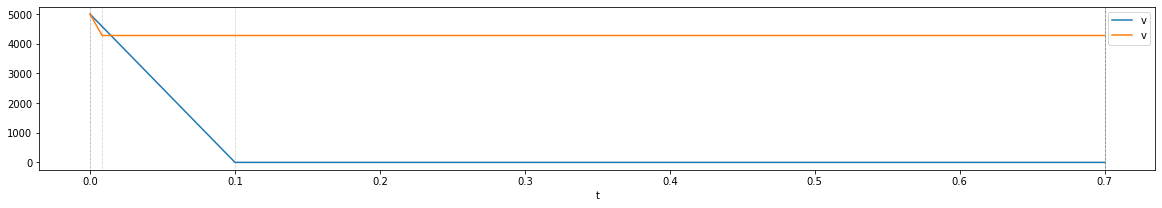

In [90]:
from trajectory.planner import max_v0_for_x

def run_segment(moves, limits, update=True):
    from trajectory.planner import ValidationError, ConvergenceError
    sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000)])   
    
    s = sl.rmove(moves, update = update)  

    for js, (v_0_max, v_0, v_1_max) in zip(s,limits):
        js.v_0_max = v_0_max
        js.v_0 = v_0
        js.v_1_max = v_1_max   
    
    return sl


sl = run_segment([250,3000], [(5000, 5000, 0), (5000, 5000, 5000)], False)
sl.update()

plot_segment_list(sl.dataframe)
sl.dataframe

,t,seg,axis,x,v0m,v_i,v_f,v1m,ss,del_t,calc_x,err
0,0.014286,0,0,5.0,0,0.00,729.48,0,a,0.014286,5.210566,-0.210566
1,0.685714,0,0,490.0,0,729.48,729.48,0,c,0.671429,489.793735,0.206265
2,0.700000,0,0,5.0,0,729.48,0.00,0,d,0.014286,5.210566,-0.210566
3,0.008333,0,1,40.0,5000,5000.00,4583.33,0,a,0.008333,39.930382,0.069618
4,0.608333,0,1,2750.0,5000,4583.33,4583.33,0,c,0.600000,2749.998000,0.002000
5,0.700000,0,1,210.0,5000,4583.33,0.00,0,d,0.091667,210.069368,-0.069368


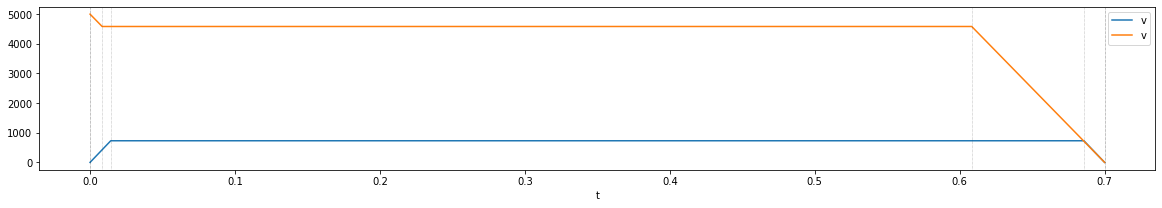

In [92]:
sl = run_segment([500,3000], [(0, 0, 0), (5000, 5000, 0)])
sl.update()
plot_segment_list(sl.dataframe)
sl.dataframe


# Classification

In [ ]:
from collections import defaultdict
from random import shuffle
from trajectory.planner import classify, kind_icon_map

# Make new classification tests
dd = defaultdict(set)
for _ in range(2000):
    x = max(randint(-100,1000), 0)
    v_0 = min(max(randint(-3000, av[0]+1000), 0), av[0])
    v_1 = min(max(randint(-3000, av[0]+1000), 0), av[0])
    args = (x, v_0, v_1, *av)
    r = classify(*args)
    
    dd[r].add(args)

l = []
for k, s in dd.items():
    s = list(s)
    shuffle(s)
    for v in s[:10]:
        l.append((v,k.name))
    

In [56]:
class_test = [
 ((991, 3270, 2029, 5000, 50000), 'TRAPZEZOID'),
 ((491, 4113, 5000, 5000, 50000), 'TRAPZEZOID'),
 ((646, 3407, 4052, 5000, 50000), 'TRAPZEZOID'),
 ((546, 0, 0, 5000, 50000), 'TRAPZEZOID'),
 ((985, 1309, 4067, 5000, 50000), 'TRAPZEZOID'),
 ((944, 4496, 1129, 5000, 50000), 'TRAPZEZOID'),
 ((606, 2337, 2051, 5000, 50000), 'TRAPZEZOID'),
 ((514, 1783, 2992, 5000, 50000), 'TRAPZEZOID'),
 ((560, 3763, 556, 5000, 50000), 'TRAPZEZOID'),
 ((373, 4927, 5000, 5000, 50000), 'TRAPZEZOID'),

 ((173, 3548, 3826, 5000, 50000), 'TROUGH'),
 ((188, 4748, 425, 5000, 50000), 'TROUGH'),
 ((30, 3444, 2552, 5000, 50000), 'TROUGH'),
 ((193, 1018, 4588, 5000, 50000), 'TROUGH'),
 ((233, 1029, 2812, 5000, 50000), 'TROUGH'),
 ((25, 2719, 1903, 5000, 50000), 'TROUGH'),
 ((7, 405, 2519, 5000, 50000), 'TROUGH'),
 ((13, 765, 5000, 5000, 50000), 'TROUGH'),
 ((1, 4200, 375, 5000, 50000), 'TROUGH'),
 ((10, 4752, 2896, 5000, 50000), 'TROUGH'),
    
    
 ((289, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((369, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((71, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((252, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((305, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((133, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((390, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((434, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((231, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((281, 0, 0, 5000, 50000), 'TRIANGLE'),
  
 ((629, 0, 3151, 5000, 50000), 'ACEL'),
 ((918, 0, 4129, 5000, 50000), 'ACEL'),
 ((299, 0, 1317, 5000, 50000), 'ACEL'),
 ((576, 0, 570, 5000, 50000), 'ACEL'),
 ((784, 0, 2494, 5000, 50000), 'ACEL'),
 ((393, 0, 188, 5000, 50000), 'ACEL'),
 ((618, 0, 4152, 5000, 50000), 'ACEL'),
 ((862, 0, 1289, 5000, 50000), 'ACEL'),
 ((71, 0, 1392, 5000, 50000), 'ACEL'),
 ((123, 0, 4364, 5000, 50000), 'ACEL'),
    
 ((545, 441, 0, 5000, 50000), 'CLIFF'),
 ((987, 3106, 0, 5000, 50000), 'CLIFF'),
 ((836, 2502, 0, 5000, 50000), 'CLIFF'),
 ((418, 558, 0, 5000, 50000), 'CLIFF'),
 ((559, 904, 0, 5000, 50000), 'CLIFF'),
 ((202, 1662, 0, 5000, 50000), 'CLIFF'),
 ((270, 5000, 0, 5000, 50000), 'CLIFF'),
 ((257, 1856, 0, 5000, 50000), 'CLIFF'),
 ((381, 3522, 0, 5000, 50000), 'CLIFF'),
 ((869, 2426, 0, 5000, 50000), 'CLIFF'),
    
 ((115, 5000, 0, 5000, 50000), 'DECEL'),
 ((25, 1785, 0, 5000, 50000), 'DECEL'),
 ((53, 5000, 0, 5000, 50000), 'DECEL'),
 ((218, 3779, 0, 5000, 50000), 'DECEL'),
 ((35, 2898, 0, 5000, 50000), 'DECEL'),
 ((66, 4563, 0, 5000, 50000), 'DECEL'),
 ((100, 4458, 0, 5000, 50000), 'DECEL'),
 ((87, 5000, 0, 5000, 50000), 'DECEL'),
 ((109, 2709, 0, 5000, 50000), 'DECEL'),
 ((42, 4511, 0, 5000, 50000), 'DECEL'),
    
 ((0, 0, 3438, 5000, 50000), 'ZERO'),
 ((0, 4255, 4443, 5000, 50000), 'ZERO'),
 ((0, 2960, 2762, 5000, 50000), 'ZERO'),
 ((0, 259, 116, 5000, 50000), 'ZERO'),
 ((0, 326, 1424, 5000, 50000), 'ZERO'),
 ((0, 3923, 0, 5000, 50000), 'ZERO'),
 ((0, 0, 3739, 5000, 50000), 'ZERO'),
 ((0, 4587, 1189, 5000, 50000), 'ZERO'),
 ((0, 2137, 5000, 5000, 50000), 'ZERO'),
 ((0, 2911, 0, 5000, 50000), 'ZERO'),

]


In [57]:
for args, name in class_test:
    assert classify(*args).name == name
